In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyriemann

In [2]:
import warrior as war

WARRIOR
   brain initialized
   network initialized


In [4]:
def matrix_from_vector(v, n):
    matrix = np.zeros((n, n))
    i_upp = np.triu_indices(n, 0)
    matrix[i_upp] = v
    i_low = np.tril_indices(n, -1)
    matrix[i_low] = matrix.T[i_low]
    
    return matrix

In [5]:
file = '../data_local/dz_data/twin_1_test.npy'

In [6]:
timeseries = np.load(file)
timeseries.shape

(63, 1190, 414)

In [7]:
N_SUBJECTS = timeseries.shape[0]
N_NODES = timeseries.shape[2]
N_EDGES = int((N_NODES*(N_NODES-1)/2))
print(f'Subjects: {N_SUBJECTS}\nNodes: {N_NODES}\nEdges: {N_EDGES}')

Subjects: 63
Nodes: 414
Edges: 85491


### Obtain regular FCs

In [8]:
fcs = np.zeros((N_SUBJECTS, N_NODES, N_NODES))
for idx, ts in enumerate(timeseries):
    corr = np.corrcoef(ts.T)
    fcs[idx] = corr
fcs.shape

(63, 414, 414)

In [9]:
upper_vectors = np.zeros((N_SUBJECTS, N_EDGES))
for idx, fc in enumerate(fcs):
        vec = war.brain.upper_vectorization(fc)
        upper_vectors[idx] = vec
upper_vectors.shape

(63, 85491)

### Regularize FCs

In [10]:
regularized_fcs = np.zeros((N_SUBJECTS, N_NODES, N_NODES))
for idx, fc in enumerate(fcs):
    fc_r = fc + np.eye(fc.shape[0])*0.01
    regularized_fcs[idx] = fc_r
regularized_fcs.shape

(63, 414, 414)

### Tangent transformation (PyRiemann)

In [11]:
selected_fcs = regularized_fcs[:10, :,:]
selected_fcs.shape

(10, 414, 414)

In [12]:
tangent_proyection = pyriemann.tangentspace.TangentSpace(metric='riemann')

In [13]:
tangent_proyection.fit(selected_fcs)

TangentSpace()

In [14]:
tangent_vectors = tangent_proyection.transform(regularized_fcs)
tangent_vectors.shape

(63, 85905)

In [15]:
tangent_fcs = np.zeros((N_SUBJECTS, N_NODES, N_NODES))
for idx, tv in enumerate(tangent_vectors):
    tfc = matrix_from_vector(tv, N_NODES)
    tangent_fcs[idx] = tfc
tangent_fcs.shape

(63, 414, 414)

### FCs vs Tangent FCs

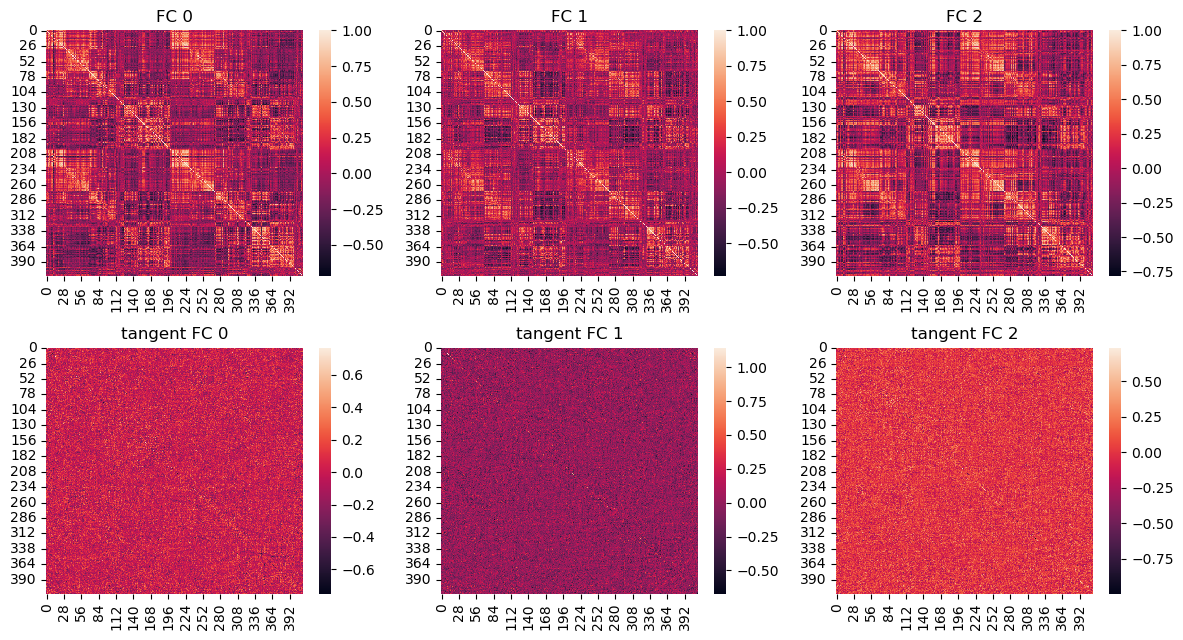

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6.5))

for i in range(3):
    ax = axes[0][i]
    ax.set_title(f'FC {i}')
    sns.heatmap(fcs[i], ax=ax)

    ax = axes[1][i]
    ax.set_title(f'tangent FC {i}')
    sns.heatmap(tangent_fcs[i], ax=ax)

plt.tight_layout()
plt.show()